In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
import usefull_funcs
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import matplotlib.patches as mpatches
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from scipy import stats
plt.style.use('fivethirtyeight')
sns.set(font_scale= 1)

import warnings
warnings.filterwarnings("ignore")


import time
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, \
    plot_confusion_matrix, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, \
    cross_val_score, StratifiedKFold, cross_validate
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline

# Functions

In [2]:
def initial_sss(df, label, test_size, out_file):

    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size,
                                 random_state=42)
    for train_index, test_index in sss.split(df, df[label]):
        print("TRAIN:", train_index, "TEST:", test_index)
        train_df = df.loc[train_index]
        test_df = df.loc[test_index]

    print(f'Train shape: {train_df.shape}')
    print(f'Train shape: {test_df.shape}')

    print(f'Train value counts: {train_df.Class.value_counts()}')
    print(f'Test value counts: {test_df.Class.value_counts()}')

    train_df.to_csv(f'{out_file}/train_df', index=False)
    test_df.drop(label, 1).to_csv(f'{out_file}/test_df', index=False)
    test_df[label].to_csv(f'{out_file}/test_df_y_true', index=False)


def final_pipeline_test(X_sss, y_sss):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train, test in sss.split(X_sss, y_sss):
        X_train, y_train = X.loc[train], y.loc[train]
        X_test, y_test = X.loc[test], y.loc[test]

        steps = [('scaler', StandardScaler()),
                 ('SMOTETomek', SMOTETomek()),
                 ('QDA', QuadraticDiscriminantAnalysis())]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        print_metrcis(y_test, y_pred)


def print_metrcis(y_test, y_pred):
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')


# output already made in /data
def lazy_cls(X, y, output_csv=False):
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
    )

    clf = LazyClassifier()
    models,predictions = clf.fit(X_train, X_test, y_train, y_test)

    if output_csv:
        models.to_csv('data/lazy_cls.csv')

    print(models)


def iqr_removal(df, threshold, col_list):

    print(f'Before removal: \n {df["Class"].value_counts()}')
    def outlier_treatment(datacolumn):
        sorted(datacolumn)
        q1, q3 = np.percentile(datacolumn , [25,75])
        iqr = q3 - q1
        lower_range = q1 - (threshold * iqr)
        upper_range = q3 + (threshold * iqr)

        return lower_range,upper_range

    for col in col_list:
        lower_range, upper_range = outlier_treatment(df[col])
        outliers = df.loc[(df[col] > upper_range) | (df[col] < lower_range)]
        outliers_indexes = outliers.index
        df = df.drop(outliers_indexes)

    print(f'After removal: \n {df["Class"].value_counts()}')

    return df


def balanced_heatmap(df):
    label = 'Class'
    X = df.drop(label, 1)
    y = df[label]

    X_resampled, y_resmapled = smote_tomek(X, y)

    X_resampled['Class'] = y_resmapled
    df_resampled = X_resampled
    corr = df_resampled.corr()

    sns.heatmap(corr)

    return corr

def get_most_corr_i(df_corr, corr_threshold):
    df_corr = df_corr.abs()
    filt = df_corr['Class'] >= corr_threshold
    most_corr_i = df_corr[filt].drop('Class').index.tolist()

    return most_corr_i


def iqr_removal_effect(df, out_col, threshold):
    amount_col = df[out_col]
    print(df['Class'].value_counts())

    lower_range, upper_range = usefull_funcs.outlier_treatment(amount_col,
                                                               threshold)
    print(f'Lower range: {lower_range}')
    print(f'Upper range: {upper_range}')

    print('Gets removed:')
    outlier_amount_df = df[df[out_col] > upper_range]
    print(outlier_amount_df['Class'].value_counts())


# Preprocessing

### Resampling methods

In [3]:
def test_sampling(X, y, sampling_func):
    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

    print('-' * 30)
    print(f'SAMPLING: {sampling_func.__name__}')

    for train, test in sss.split(X, y):
        X_train, y_train = X.loc[train], y.loc[train]
        X_test, y_test = X.loc[test], y.loc[test]

        sampling_start = time.time()
        print(f'Value counts before resampling: \n {y.value_counts()}')

        X_resampled, y_resampled = sampling_func(X_train, y_train)

        sampling_stop = time.time()
        print(f'Sampling time: {sampling_stop - sampling_start} s')
        print(f'Value counts after resampling: \n {y_resampled.value_counts()}')


        model = QuadraticDiscriminantAnalysis()
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)

        print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
        print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
        print(f'Precision: {precision_score(y_test, y_pred)}')
        print(f'Recall: {recall_score(y_test, y_pred)}')
        print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

    print('-' * 30)


def visualize_clusters(X, y, resampling_func):
    X_resampled, y_resampled = resampling_func(X, y)

    pca = TruncatedSVD(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_resampled, y_resampled)

    sns.scatterplot(X_pca[: ,-2], X_pca[: , -1], hue=y_resampled)
    plt.show()




# SAMPLING -------------------------
def rand_us(X, y):
    minority_count = y.value_counts()[1]
    rus = RandomUnderSampler(
        random_state=42,
        sampling_strategy = {0 : minority_count}
    )

    X_rand_undersampled, y_rand_undersampled = rus.fit_sample(X, y)

    return X_rand_undersampled, y_rand_undersampled


def near_miss_us(X, y):
    nm = NearMiss(sampling_strategy='majority')
    X_nm, y_nm = nm.fit_resample(X, y)

    return X_nm, y_nm

def smote_os(X, y):
    smote = SMOTE(sampling_strategy='minority', random_state=43)
    X_smote, y_smote = smote.fit_resample(X, y)

    return  X_smote, y_smote


def combined_us_os(X, y):

    smote = SMOTE(sampling_strategy=0.1, random_state=43)
    X_smote, y_smote = smote.fit_resample(X, y)

    # majority_half = int(X.shape[0] / 2)
    nm = NearMiss(sampling_strategy='majority')
    X_nm, y_nm = nm.fit_resample(X_smote, y_smote)

    return X_nm, y_nm


def smote_tomek(X, y):
    smote_t = SMOTETomek(sampling_strategy='minority', random_state=42)
    X_smote, y_smote = smote_t.fit_resample(X, y)

    return  X_smote, y_smote


def smote_enn(X, y):
    smote_e = SMOTEENN(sampling_strategy='minority', random_state=42)
    X_smote, y_smote = smote_e.fit_resample(X, y)

    return  X_smote, y_smote

# SAMPLING -------------------------









#Data colection
Used just for the first time

In [4]:
# df = pd.read_csv('data/creditcard.csv')
# df

# StratifiedShuffleSplit into train and test/y_true sets
Used just for the first time

In [5]:
# initial_sss(df, 'Class', 0.2, 'data')

# Missing data

### Reading in trainting data

In [6]:
df = pd.read_csv('data/train_df')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,161919.00,1.95,-0.75,-1.36,-0.66,1.50,4.02,-1.48,1.14,1.41,...,0.08,0.30,0.31,0.69,-0.35,-0.39,0.08,-0.03,7.32,0
1,124477.00,2.04,-0.05,-3.06,0.25,2.94,3.30,-0.00,0.67,0.05,...,0.04,0.23,0.04,0.71,0.51,-0.47,0.00,-0.07,2.99,0
2,41191.00,-0.99,0.60,0.71,-0.99,-0.83,1.96,-2.21,-5.04,0.00,...,-2.80,0.11,-0.44,-0.93,0.83,0.91,0.04,0.19,175.10,0
3,132624.00,2.29,-1.50,-0.75,-1.67,-1.39,-0.35,-1.43,0.01,-1.12,...,-0.14,0.08,0.21,-0.54,-0.28,-0.16,0.02,-0.06,6.10,0
4,59359.00,-0.45,-1.01,0.12,-3.45,0.72,-0.15,0.50,-0.11,-0.04,...,-0.24,-0.17,-0.01,-1.36,-0.29,-0.14,-0.03,-0.06,86.10,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227845 non-null  float64
 1   V1      227845 non-null  float64
 2   V2      227845 non-null  float64
 3   V3      227845 non-null  float64
 4   V4      227845 non-null  float64
 5   V5      227845 non-null  float64
 6   V6      227845 non-null  float64
 7   V7      227845 non-null  float64
 8   V8      227845 non-null  float64
 9   V9      227845 non-null  float64
 10  V10     227845 non-null  float64
 11  V11     227845 non-null  float64
 12  V12     227845 non-null  float64
 13  V13     227845 non-null  float64
 14  V14     227845 non-null  float64
 15  V15     227845 non-null  float64
 16  V16     227845 non-null  float64
 17  V17     227845 non-null  float64
 18  V18     227845 non-null  float64
 19  V19     227845 non-null  float64
 20  V20     227845 non-null  float64
 21  V21     22

In [8]:
missing_data = df.isnull().sum()
print('Amount of missing data: ')
print(missing_data.sum())

Amount of missing data: 
0


# EDA


In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,...,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00
mean,94885.09,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,...,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,88.18,0.00
std,47488.42,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.63,0.61,0.52,0.48,0.40,0.33,250.72,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54228.00,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.64,0.00
50%,84805.00,0.02,0.06,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139364.00,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.49,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,6.07,3.52,31.61,33.85,25691.16,1.00


In [10]:
# usefull_funcs.hist_for_loop(df)

In [11]:
# usefull_funcs.box_plot_for_loop(df)

### Outlier treatment


In [12]:
# try removing outliers or applying transformation(log, sqrt, bc)
# amount during testing
# Didnt work, returns nans bcs of 0s and negative values

In [13]:
# Didnt work, removed too much data even with multiplier of 3
# instead of 1.5
# print(df['Class'].value_counts())
# iqr_removed = iqr_removal(df)
# print(iqr_removed['Class'].value_counts())


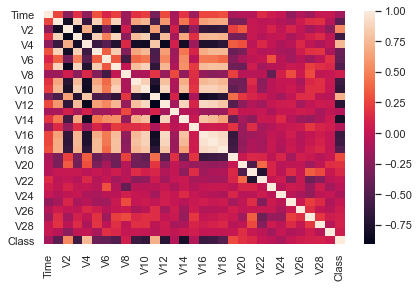

In [14]:
df_corr = balanced_heatmap(df)

In [15]:
most_corr_i = get_most_corr_i(df_corr, 0.6)
most_corr_i

['V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16']

In [16]:
for col in most_corr_i:
    print('-' * 30)
    print(f'Column: {col}')
    iqr_removal_effect(df, col, 3)
    print('-' * 30)

------------------------------
Column: V4
0    227451
1       394
Name: Class, dtype: int64
Lower range: -5.61528726211039
Upper range: 5.510456851601411
Gets removed:
0    234
1    141
Name: Class, dtype: int64
------------------------------
------------------------------
Column: V9
0    227451
1       394
Name: Class, dtype: int64
Lower range: -4.355986978698251
Upper range: 4.31393409700388
Gets removed:
0    757
Name: Class, dtype: int64
------------------------------
------------------------------
Column: V10
0    227451
1       394
Name: Class, dtype: int64
Lower range: -3.506026249991024
Upper range: 3.4248405175366092
Gets removed:
0    2093
1       1
Name: Class, dtype: int64
------------------------------
------------------------------
Column: V11
0    227451
1       394
Name: Class, dtype: int64
Lower range: -5.259747470123153
Upper range: 5.2353607193777485
Gets removed:
1    100
0     18
Name: Class, dtype: int64
------------------------------
-----------------------------

# Choosing model and sampling method

In [17]:
label = 'Class'
X = df.drop(label, 1)
y = df[label]

In [18]:
# lazy_cls(X, y)

Will use QuadraticDiscriminantAnalysis as baseline,
for testing resampling techniques:
Mean ROC AUC: 0.9741837852279357
Recall: 0.8235294117647058
Precision: 0.04890829694323144



In [19]:
# resampling_funcs = [rand_us, near_miss_us, smote_os, combined_us_os,
#                     smote_tomek, smote_enn]

# for func in resampling_funcs:
#     test_sampling(X, y, func)

Smote or combined smote are the best options for resampling data

In [20]:
# visualize_clusters(X, y, smote_tomek)

In [21]:
# final_pipeline_test(X, y)

#### Scaled smotetomek QDA:

Accuracy: 0.9745221532181966
ROC AUC: 0.911421483647818
Precision: 0.055098684210526314
Recall: 0.8481012658227848
Confusion Matrix:
[[44341  1149]
[   12    67]]



In [22]:
# todo try thresholds = [4.5, 5.5]
# Testing best iqr removal threshold
# thresholds = [3, 5, 7, 9]
# for threshold in thresholds:
#     print(f'THRESHOLD: {threshold}')
#     iqr_df = iqr_removal(df, threshold, most_corr_i)
#
#     label = 'Class'
#     X_iqr = iqr_df.drop(label, 1)
#     y_iqr = iqr_df[label]
#
#     final_pipeline_test(X_iqr, y_iqr)


# RESULTS:
# THRESHOLD: 3
# Before removal:
#  0    227451
# 1       394
# Name: Class, dtype: int64
# After removal:
#  0    222786
# 1        59
# Name: Class, dtype: int64
# Accuracy: 0.9743543718728264
# ROC AUC: 0.9141176896292531
# Precision: 0.058284762697751874
# Recall: 0.8536585365853658
# Confusion Matrix:
#  [[43356  1131]
#  [   12    70]]
# THRESHOLD: 5
# Before removal:
#  0    227451
# 1       394
# Name: Class, dtype: int64
# After removal:
#  0    226274
# 1       114
# Name: Class, dtype: int64
# Accuracy: 0.9762798710190379
# ROC AUC: 0.9326626890181994
# Precision: 0.0633245382585752
# Recall: 0.8888888888888888
# Confusion Matrix:
#  [[44132  1065]
#  [    9    72]]
# THRESHOLD: 7
# Before removal:
#  0    227451
# 1       394
# Name: Class, dtype: int64
# After removal:
#  0    226896
# 1       181
# Name: Class, dtype: int64
# Accuracy: 0.9750748634842347
# ROC AUC: 0.9209783935636647
# Precision: 0.0651085141903172
# Recall: 0.8666666666666667
# Confusion Matrix:
#  [[44206  1120]
#  [   12    78]]
# THRESHOLD: 9
# Before removal:
#  0    227451
# 1       394
# Name: Class, dtype: int64
# After removal:
#  0    227247
# 1       252
# Name: Class, dtype: int64
# Accuracy: 0.9732967032967033
# ROC AUC: 0.9060950121328035
# Precision: 0.04136833731105807
# Recall: 0.8387096774193549
# Confusion Matrix:
#  [[44233  1205]
#  [   10    52]]

# Threshold of 5 seems to give the best performance